In [1]:
# try to re-cast the problem into a more physical coordinate system. Frame it as a forecast problem - e.g. "what's the probability of a neutral density enhancement given parameters x,y,z,w,t."

In [1]:
import os
from spacepy import pycdf
from geopack import geopack
import polars as pl
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import aacgmv2
import contextlib

def calculate_magnetic_coords(lat, lon, alt, timestamp):
    # Convert UNIX timestamp to datetime
    dtime = dt.datetime.utcfromtimestamp(timestamp)
    
    # Convert datetime to Julian date
    julian_date = dtime.toordinal() + 1721424.5 + dtime.hour / 24 + dtime.minute / 1440 + dtime.second / 86400
    
    # Step 1: Initialize Geopack with the Julian date
    geopack.recalc(julian_date)  # Set Geopack with this Julian date
    
    # Convert latitude, longitude, altitude to GEO spherical coordinates
    r_geo, theta_geo = geopack.geodgeo(lat, alt, 1)  # geodgeo returns r and theta (not x, y, z)
    
    # Convert spherical GEO (r, theta, lon) to Cartesian GEO (x, y, z)
    phi = np.radians(lon)  # Longitude in radians
    theta = np.radians(90 - theta_geo)  # Convert colatitude to polar angle for Cartesian conversion
    
    x_geo = r_geo * np.sin(theta) * np.cos(phi)
    y_geo = r_geo * np.sin(theta) * np.sin(phi)
    z_geo = r_geo * np.cos(theta)
    
    # Step 2: Transform GEO to MAG Cartesian coordinates
    x_mag, y_mag, z_mag = geopack.geomag(x_geo, y_geo, z_geo, 1)  # GEO to MAG with flag=1

    # Step 3: Calculate magnetic latitude and magnetic local time
    # Magnetic latitude (degrees): calculated from z component in MAG
    magnetic_latitude = np.degrees(np.arcsin(z_mag / np.sqrt(x_mag**2 + y_mag**2 + z_mag**2)))

    # Magnetic Local Time (MLT) in hours
    ut_hours = dtime.hour + dtime.minute / 60.0 + dtime.second / 3600.0
    magnetic_longitude = np.degrees(np.arctan2(y_mag, x_mag))
    mlt = (magnetic_longitude / 15.0 + ut_hours) % 24  # Convert longitude to hours and adjust with UT

    return magnetic_latitude, mlt

def calculate_magnetic_coords_aacgm(lat, lon, alt, timestamp):
    dtime = dt.datetime.utcfromtimestamp(timestamp)
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stderr(fnull): 
            geomag_lat, geomag_lon = aacgmv2.get_aacgm_coord(lat, lon, alt, dtime)[:2]
            if geomag_lat is None or geomag_lon is None:
                return np.nan, np.nan
            try:
                ut_hours = dtime.hour + dtime.minute / 60.0
                mlt = (geomag_lon / 15.0) + ut_hours
                mlt = mlt % 24  
                return geomag_lat, mlt
            except:
                return np.nan, np.nan  

Load IGRF coefficients ...


In [2]:
%%time

limit = 1  # Limit to this many CDF files for testing
champ_root_dir = "/Users/patrick/Dev/perceptive_techeval/data/champ-2002-2007/champ-2007/"
num_lat_bins = 180  # Number of geomagnetic latitude bins
num_mlt_bins = 48  # Number of MLT bins
num_lst_bins = 48  # Number of LST bins

df_arr = []
processed = 0

for root, dirs, files in os.walk(os.path.abspath(champ_root_dir)):
    for file in [os.path.join(root, f) for f in files[0:limit] if f.endswith(".cdf")]:
        cdf = pycdf.CDF(file)
        alt = cdf["altitude"][:] / 1000.0
        lat = cdf["latitude"][:]
        lon = cdf["longitude"][:]
        lst = cdf["local_solar_time"][:]
        valid = cdf["validity_flag"][:]
        density = cdf["density"][:]
        density_orbitmean = cdf["density_orbitmean"][:]
        time = cdf["time"][:]

        unix_timestamps = [dt.datetime.timestamp(t) for t in time]

        df = pl.DataFrame({
            "timestamp": unix_timestamps,
            "altitude": alt,
            "latitude": lat,
            "longitude": lon,
            "local_solar_time": lst,
            "validity_flag": valid,
            "density_orbitmean": density_orbitmean,
            "density": density
        })

        columns_to_check = [col for col in df.columns if col != "timestamp"]

        df = df.with_columns([
            pl.when(pl.col(col) > 1e25).then(np.nan).otherwise(pl.col(col)).alias(col)
            for col in columns_to_check
        ])

        df_arr.append(df)
        processed += 1
        if processed >= limit:
            break

df = pl.concat(df_arr)

geomagnetic_latitudes, mlts = zip(*[
    calculate_magnetic_coords_aacgm(row[0], row[1], row[2], row[3])
    for row in zip(df["latitude"], df["longitude"], df["altitude"], df["timestamp"])
])

df = df.with_columns([
    pl.Series("geomagnetic_latitude", geomagnetic_latitudes),
    pl.Series("mlt", mlts)
])

geomag_lat_bins = np.arcsin(np.linspace(-1, 1, num_lat_bins + 1)) * (180 / np.pi)
mlt_bins = np.linspace(0, 24, num_mlt_bins + 1)
lst_bins = np.linspace(0, 24, num_lst_bins + 1)

# Assign each row to a geomagnetic latitude bin and MLT bin
lat_bin_indices = np.digitize(df["geomagnetic_latitude"], geomag_lat_bins) - 1  # Subtract 1 for 0-based index
mlt_bin_indices = np.digitize(df["mlt"], mlt_bins) - 1  # Subtract 1 for 0-based index
lst_bin_indices = np.digitize(df["local_solar_time"], lst_bins) - 1  # Subtract 1 for 0-based index

# Add bin indices and grid index to DataFrame
df = df.with_columns([
    pl.Series("lat_bin_index", lat_bin_indices),
    pl.Series("mlt_bin_index", mlt_bin_indices),
    pl.Series("lst_bin_index", lst_bin_indices)
])

df = df.drop_nulls()
df.write_csv("df.csv")

CPU times: user 1.06 s, sys: 1.84 s, total: 2.9 s
Wall time: 3.65 s


In [3]:
df

timestamp,altitude,latitude,longitude,local_solar_time,validity_flag,density_orbitmean,density,geomagnetic_latitude,mlt,lat_bin_index,mlt_bin_index,lst_bin_index
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
1.1955e9,363.735018,-63.969321,123.038927,8.448712,0.0,1.3856e-12,1.1696e-12,-79.174288,19.903612,1,39,16
1.1955e9,363.523534,-63.320587,123.155861,8.459285,0.0,1.3861e-12,1.1738e-12,-78.496242,19.932876,1,39,16
1.1955e9,363.308092,-62.671597,123.265817,8.469393,0.0,1.3865e-12,1.1843e-12,-77.816111,19.958655,2,39,16
1.1955e9,363.088786,-62.022361,123.36928,8.479068,0.0,1.3870e-12,1.1965e-12,-77.134054,19.981486,2,39,16
1.1955e9,362.865709,-61.372889,123.466692,8.488339,0.0,1.3875e-12,1.2013e-12,-76.450211,20.001802,2,40,16
…,…,…,…,…,…,…,…,…,…,…,…,…
1.1955e9,348.941751,-28.480443,-51.005196,20.828203,0.0,1.4741e-12,1.5385e-12,-24.21836,8.052942,53,16,41
1.1955e9,349.215414,-29.137771,-51.005915,20.830932,0.0,1.4744e-12,1.5252e-12,-24.682381,8.046213,52,16,41
1.1955e9,349.490964,-29.794983,-51.006111,20.833697,0.0,1.4746e-12,1.5008e-12,-25.149042,8.039835,51,16,41


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'geomagnetic_latitude' and 'lst' columns are in degrees and hours respectively
# Filter northern hemisphere data (latitude >= 60)
df_north = df.filter((pl.col("geomagnetic_latitude") >= 60) & (pl.col("density").is_not_nan()))

lat_north = df_north["geomagnetic_latitude"].to_numpy()
lst_north = df_north["local_solar_time"].to_numpy()
density_north = df_north["density"].to_numpy()

# Filter southern hemisphere data (latitude < -60)
df_south = df.filter((pl.col("geomagnetic_latitude") < -60) & (pl.col("density").is_not_nan()))

lat_south = df_south["geomagnetic_latitude"].to_numpy()
lst_south = df_south["local_solar_time"].to_numpy()
density_south = df_south["density"].to_numpy()

# Define the number of bins for radius (latitude) and angle (LST)
num_lat_bins = 30
num_lst_bins = 24

# Calculate 2D histograms for each hemisphere
hist_north, lat_edges_north, lst_edges_north = np.histogram2d(
    lat_north, lst_north, bins=(num_lat_bins, num_lst_bins), weights=density_north, density=True
)
hist_south, lat_edges_south, lst_edges_south = np.histogram2d(
    lat_south, lst_south, bins=(num_lat_bins, num_lst_bins), weights=density_south, density=True
)

# Prepare mesh for polar plotting
theta_north = np.linspace(0, 2 * np.pi, num_lst_bins, endpoint=False)
r_north = np.linspace(0, 1, num_lat_bins)

theta_south = np.linspace(0, 2 * np.pi, num_lst_bins, endpoint=False)
r_south = np.linspace(0, 1, num_lat_bins)

theta_grid_north, r_grid_north = np.meshgrid(theta_north, r_north)
theta_grid_south, r_grid_south = np.meshgrid(theta_south, r_south)

# Plot northern hemisphere
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.pcolormesh(theta_grid_north, r_grid_north, hist_north.T, shading='auto', cmap='jet')
plt.colorbar(c, ax=ax, label="Average Density (Northern Hemisphere)", pad=0.1)
ax.set_title("Average Neutral Density by Geomagnetic Latitude and LST (Northern Hemisphere)")
plt.show()

# Plot southern hemisphere
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.pcolormesh(theta_grid_south, r_grid_south, hist_south.T, shading='auto', cmap='jet')
plt.colorbar(c, ax=ax, label="Average Density (Southern Hemisphere)", pad=0.1)
ax.set_title("Average Neutral Density by Geomagnetic Latitude and LST (Southern Hemisphere)")
plt.show()


ValueError: autodetected range of [nan, nan] is not finite

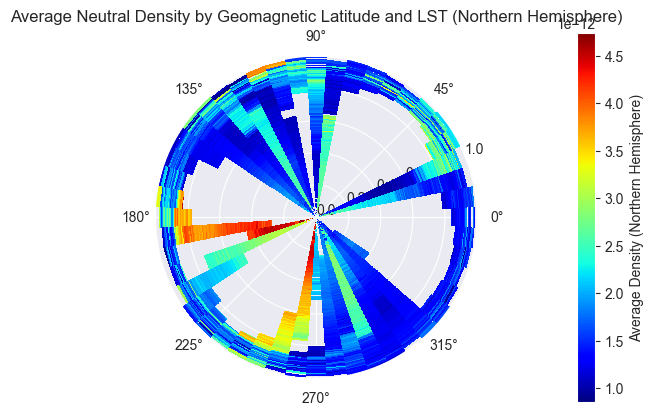

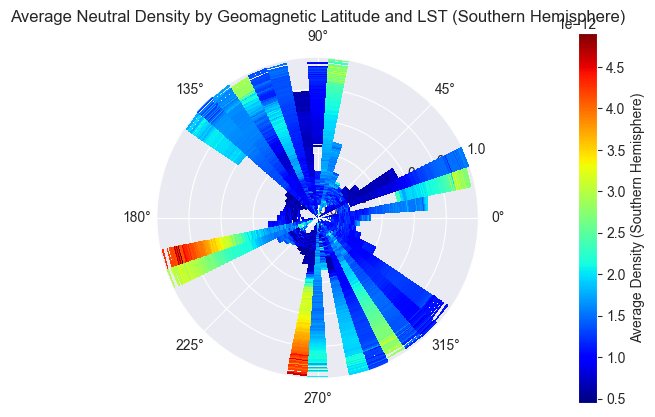

In [153]:
# Define separate latitude bins for northern and southern hemispheres

geomag_lat_bins_north = np.linspace(0, 90, num_lat_bins + 1)
geomag_lat_bins_south = np.linspace(-90, 0, num_lat_bins + 1)

# Filter the DataFrame for northern and southern hemispheres
df_north = df.filter(pl.col("geomagnetic_latitude") >= 0)
df_south = df.filter(pl.col("geomagnetic_latitude") < 0)

# Calculate lat_bin_index using hemisphere-specific bins
lat_bin_indices_north = np.digitize(df_north["geomagnetic_latitude"], geomag_lat_bins_north) - 1
lat_bin_indices_south = np.digitize(df_south["geomagnetic_latitude"], geomag_lat_bins_south) - 1

# Assign calculated indices back to the DataFrames
df_north = df_north.with_columns([
    pl.Series("lat_bin_index", lat_bin_indices_north)
])

df_south = df_south.with_columns([
    pl.Series("lat_bin_index", lat_bin_indices_south)
])

# Group and calculate mean density for each hemisphere
density_averages_north = df_north.group_by(["lat_bin_index", "lst_bin_index"]).agg([
    pl.col("density").mean().alias("mean_density")
])

density_averages_south = df_south.group_by(["lat_bin_index", "lst_bin_index"]).agg([
    pl.col("density").mean().alias("mean_density")
])

# Initialize density grids
density_grid_north = np.full((num_lat_bins, num_lst_bins), np.nan)
density_grid_south = np.full((num_lat_bins, num_lst_bins), np.nan)

# Populate density grids with mean density values
for row in density_averages_north.iter_rows():
    lat_idx, lst_idx, mean_density = row
    if 0 <= lat_idx < num_lat_bins and 0 <= lst_idx < num_lst_bins:
        density_grid_north[lat_idx, lst_idx] = mean_density

for row in density_averages_south.iter_rows():
    lat_idx, lst_idx, mean_density = row
    if 0 <= lat_idx < num_lat_bins and 0 <= lst_idx < num_lst_bins:
        density_grid_south[lat_idx, lst_idx] = mean_density

# Prepare grid for polar plotting
r = np.linspace(0, 1, num_lat_bins)  # Normalize radius for plotting
theta = np.linspace(0, 2 * np.pi, num_lst_bins, endpoint=False)
theta_grid, r_grid_north = np.meshgrid(theta, r)
_, r_grid_south = np.meshgrid(theta, r)

# Plot northern hemisphere
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.pcolormesh(theta_grid, r_grid_north, density_grid_north, shading='auto', cmap='jet')
plt.colorbar(c, label="Average Density (Northern Hemisphere)", pad=.2)
ax.set_title("Average Neutral Density by Geomagnetic Latitude and LST (Northern Hemisphere)")
plt.show()

# Plot southern hemisphere
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.pcolormesh(theta_grid, r_grid_south, density_grid_south, shading='auto', cmap='jet')
plt.colorbar(c, label="Average Density (Southern Hemisphere)", pad=.2)
ax.set_title("Average Neutral Density by Geomagnetic Latitude and LST (Southern Hemisphere)")
plt.show()


In [140]:
density_grid_north

array([[1.28819323e-12, 1.61130274e-12, 1.03982543e-12, ...,
        1.19159096e-12, 1.19608224e-12, 1.08624137e-12],
       [1.10979660e-12, 1.84200520e-12, 1.06424405e-12, ...,
        1.23404096e-12, 1.17502485e-12, 1.23001204e-12],
       [1.22452933e-12, 1.58349499e-12, 1.14812752e-12, ...,
        1.24900381e-12, 1.11577300e-12, 1.27940265e-12],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

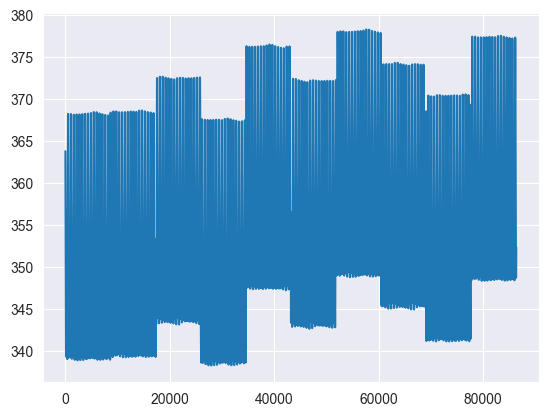

In [141]:
plt.plot(df["altitude"])

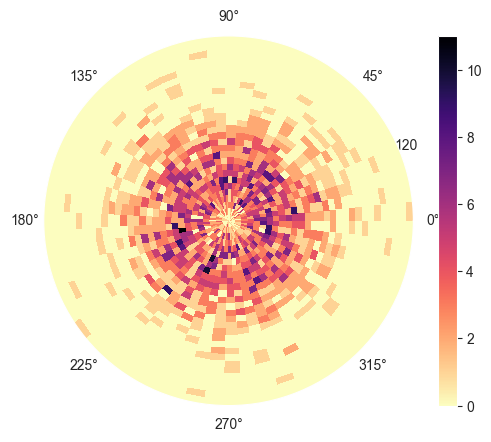

In [6]:
# two input arrays
azimut = np.random.rand(3000)*2*np.pi
radius = np.random.rayleigh(29, size=3000)

# define binning
rbins = np.linspace(0,radius.max(), 30)
abins = np.linspace(0,2*np.pi, 60)

#calculate histogram
hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
A, R = np.meshgrid(abins, rbins)

# plot
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")
fig.colorbar(pc)

plt.show()

In [7]:
radius

array([13.51057938, 33.0640676 , 37.72185046, ..., 11.87245715,
       28.74446359, 35.06770834])